✅ Found ┊ model=rtma ┊ product=anl ┊ 2023-Feb-22 12:00 UTC F00 ┊ GRIB2 @ local ┊ IDX @ aws


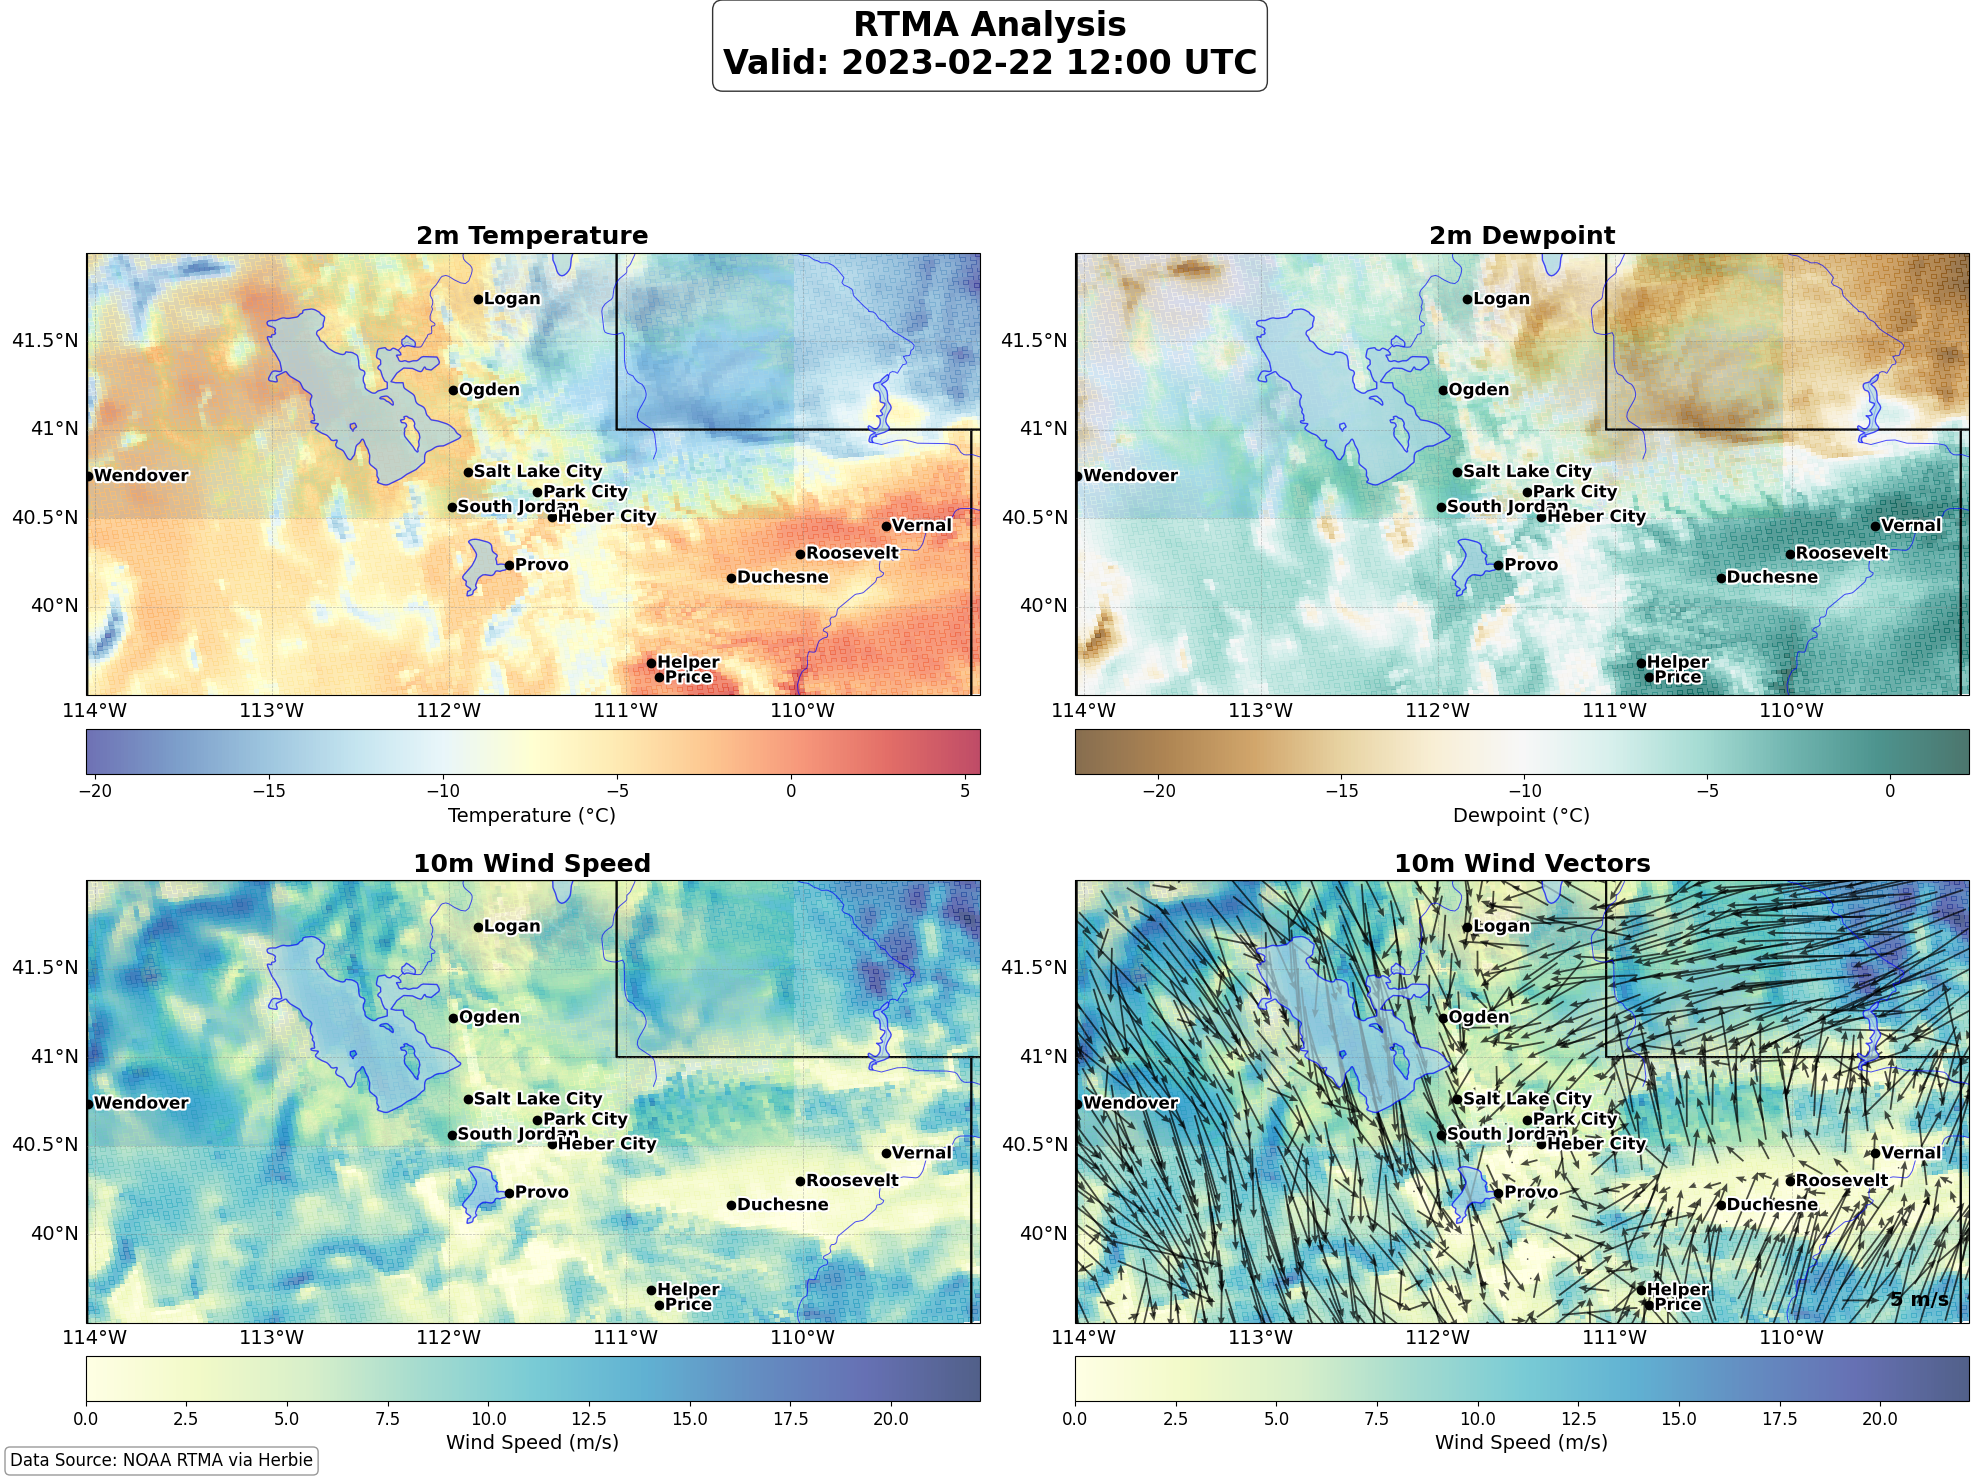

In [5]:
import matplotlib.pyplot as plt
import cartopy.crs as ccrs
import cartopy.feature as cfeature
from herbie import Herbie
import numpy as np
import os
import xarray as xr
import pandas as pd
from datetime import datetime, timedelta
import warnings
import matplotlib.colors as mcolors
import matplotlib.patches as mpatches
import matplotlib.patheffects as patheffects
from cartopy.io import shapereader
from cartopy.feature import ShapelyFeature
import scipy.ndimage as ndimage

plt.style.use('default')
plt.rcParams.update({
    'font.size': 14,
    'axes.titlesize': 16,
    'axes.labelsize': 14,
    'xtick.labelsize': 12,
    'ytick.labelsize': 12,
    'legend.fontsize': 12,
    'figure.titlesize': 24
})

warnings.filterwarnings('ignore')


def load_dem_data(lon_min, lon_max, lat_min, lat_max):
    import rasterio
    from rasterio.warp import transform_bounds

    dem_file = "/Users/a02428741/PycharmProjects/snowshadow/notebooks/uinta_dem_data/merged_dem.tif"

    if dem_file and os.path.exists(dem_file):
        with rasterio.open(dem_file) as src:
            dst_crs = src.crs
            src_crs = 'EPSG:4326'
            transformed_bounds = transform_bounds(src_crs, dst_crs, lon_min, lat_min, lon_max, lat_max)
            window = src.window(*transformed_bounds)
            dem = src.read(1, window=window)
            win_transform = src.window_transform(window)
            height, width = dem.shape
            lon = np.linspace(win_transform.c, win_transform.c + width * win_transform.a, width)
            lat = np.linspace(win_transform.f, win_transform.f + height * win_transform.e, height)
            return dem, lon, lat

    return None, None, None


def download_and_visualize_rtma(date_str, output_dir="./rtma_analysis",
                               bbox=(39.5, -114.05, 42.0, -109.0),
                               create_multiplot=True):
    if not os.path.exists(output_dir):
        os.makedirs(output_dir)

    date_safe = date_str.replace(' ', '_').replace(':', '')
    lat_min, lon_min, lat_max, lon_max = bbox

    H = Herbie(date_str, model="rtma", product="anl", fxx=0)
    file_path = H.download()

    if not os.path.exists(file_path):
        return

    inventory = H.inventory()
    temp_vars_info = []
    for idx, row in inventory.iterrows():
        var_name = row['variable']
        level = row['level']
        search_this = row['search_this']

        if ('TMP' in var_name or 'DPT' in var_name or 'UGRD' in var_name or
            'VGRD' in var_name or 'WIND' in var_name):
            search_string = f"{var_name}:{level}"
            if ':' in search_this:
                search_string = search_this
            temp_vars_info.append((var_name, level, search_string))

    if not temp_vars_info:
        return

    tmp_ds = None
    tmp_var = None
    tmp_result = H.xarray("TMP:2 m above ground")

    if isinstance(tmp_result, list):
        for ds in tmp_result:
            if 't2m' in ds.data_vars:
                tmp_ds = ds
                tmp_var = 't2m'
                break
    else:
        tmp_ds = tmp_result
        if tmp_ds and len(tmp_ds.data_vars) > 0:
            tmp_var = list(tmp_ds.data_vars)[0]

    dpt_ds = None
    dpt_var = None
    dpt_result = H.xarray("DPT:2 m above ground")

    if isinstance(dpt_result, list):
        for ds in dpt_result:
            if 'd2m' in ds.data_vars:
                dpt_ds = ds
                dpt_var = 'd2m'
                break
    else:
        dpt_ds = dpt_result
        if dpt_ds and len(dpt_ds.data_vars) > 0:
            dpt_var = list(dpt_ds.data_vars)[0]

    wind_ds = None
    wind_var = None
    wind_result = H.xarray("WIND:10 m above ground")

    if isinstance(wind_result, list):
        for ds in wind_result:
            if 'si10' in ds.data_vars:
                wind_ds = ds
                wind_var = 'si10'
                break
    else:
        wind_ds = wind_result
        if wind_ds and len(wind_ds.data_vars) > 0:
            wind_var = list(wind_ds.data_vars)[0]

    u_ds = None
    u_var = None
    v_ds = None
    v_var = None

    u_result = H.xarray("UGRD:10 m above ground")
    if isinstance(u_result, list):
        for ds in u_result:
            if 'u10' in ds.data_vars:
                u_ds = ds
                u_var = 'u10'
                break
    else:
        u_ds = u_result
        if u_ds and len(u_ds.data_vars) > 0:
            u_var = list(u_ds.data_vars)[0]

    v_result = H.xarray("VGRD:10 m above ground")
    if isinstance(v_result, list):
        for ds in v_result:
            if 'v10' in ds.data_vars:
                v_ds = ds
                v_var = 'v10'
                break
    else:
        v_ds = v_result
        if v_ds and len(v_ds.data_vars) > 0:
            v_var = list(v_ds.data_vars)[0]

    if tmp_ds is None and dpt_ds is None and wind_ds is None:
        return

    def extract_region_data(ds, var_name):
        if ds is None or var_name is None:
            return None, None, None

        if 'latitude' in ds.coords and 'longitude' in ds.coords:
            lat_coord, lon_coord = 'latitude', 'longitude'
        elif 'lat' in ds.coords and 'lon' in ds.coords:
            lat_coord, lon_coord = 'lat', 'lon'
        else:
            return None, None, None

        if ds[lon_coord].min() > 180:
            ds = ds.assign_coords({lon_coord: (((ds[lon_coord] + 180) % 360) - 180)})

        if ds[lat_coord].ndim == 1 and ds[lon_coord].ndim == 1:
            ds_region = ds.sel({lat_coord: slice(lat_max, lat_min),
                              lon_coord: slice(lon_min, lon_max)})
        else:
            lat_mask = (ds[lat_coord] >= lat_min) & (ds[lat_coord] <= lat_max)
            lon_mask = (ds[lon_coord] >= lon_min) & (ds[lon_coord] <= lon_max)
            combined_mask = lat_mask & lon_mask
            y_indices, x_indices = np.where(combined_mask)
            if len(y_indices) > 0 and len(x_indices) > 0:
                y_min, y_max = y_indices.min(), y_indices.max()
                x_min, x_max = x_indices.min(), x_indices.max()
                ds_region = ds.isel(y=slice(y_min, y_max+1), x=slice(x_min, x_max+1))
            else:
                ds_region = ds

        return ds_region, lat_coord, lon_coord

    tmp_region, tmp_lat, tmp_lon = extract_region_data(tmp_ds, tmp_var)
    dpt_region, dpt_lat, dpt_lon = extract_region_data(dpt_ds, dpt_var)
    wind_region, wind_lat, wind_lon = extract_region_data(wind_ds, wind_var)
    u_region, u_lat, u_lon = extract_region_data(u_ds, u_var) if u_ds is not None else (None, None, None)
    v_region, v_lat, v_lon = extract_region_data(v_ds, v_var) if v_ds is not None else (None, None, None)

    def get_valid_time_str(ds):
        if ds is None:
            return date_str

        if hasattr(ds, 'valid_time'):
            valid_time = ds.valid_time
            if hasattr(valid_time, 'dt'):
                return valid_time.dt.strftime('%Y-%m-%d %H:%M UTC').item()
            else:
                return str(valid_time)
        elif 'time' in ds.coords:
            return str(ds['time'].values.item())
        else:
            return date_str

    for ds in [tmp_region, dpt_region, wind_region]:
        if ds is not None:
            valid_time_str = get_valid_time_str(ds)
            break
    else:
        valid_time_str = date_str

    dem_data, dem_lon, dem_lat = load_dem_data(lon_min, lon_max, lat_min, lat_max)

    if create_multiplot:
        panel_count = sum(x is not None for x in [tmp_region, dpt_region, wind_region])
        projection = ccrs.PlateCarree()

        if panel_count == 2:
            fig, axes = plt.subplots(1, 2, figsize=(20, 8),
                                    subplot_kw={'projection': projection})
            if not isinstance(axes, np.ndarray):
                axes = np.array([axes])
        else:
            fig, axes = plt.subplots(2, 2, figsize=(20, 16),
                                    subplot_kw={'projection': projection})
            axes = axes.flatten()

        cities = {
            "Salt Lake City": (40.7608, -111.8910),
            "Ogden": (41.2230, -111.9738),
            "Provo": (40.2338, -111.6585),
            "Park City": (40.6461, -111.4980),
            "South Jordan": (40.5622, -111.9825),
            "Wendover": (40.7372, -114.0370),
            "Logan": (41.7370, -111.8338),
            "Duchesne": (40.1635, -110.4029),
            "Roosevelt": (40.2994, -110.0126),
            "Vernal": (40.4555, -109.5287),
            "Price": (39.5994, -110.8107),
            "Heber City": (40.5068, -111.4168),
            "Helper": (39.6830, -110.8541)
        }

        def setup_map_and_features(ax):
            ax.set_extent([lon_min, lon_max, lat_min, lat_max], crs=projection)

            if dem_data is not None and dem_lon is not None and dem_lat is not None:
                terrain = ax.pcolormesh(dem_lon, dem_lat, dem_data,
                                       cmap='terrain', alpha=0.5,
                                       transform=projection)
            else:
                ax.add_feature(cfeature.LAND.with_scale('10m'), facecolor='#edeae2')
                ax.add_feature(cfeature.OCEAN.with_scale('10m'), facecolor='lightblue')

            ax.add_feature(cfeature.STATES.with_scale('10m'), edgecolor="black", linewidth=1.5, facecolor="none", alpha=0.8)
            ax.add_feature(cfeature.COASTLINE.with_scale('10m'), edgecolor="black", linewidth=1.5)
            ax.add_feature(cfeature.RIVERS.with_scale('10m'), edgecolor='blue', linewidth=0.7, alpha=0.7)
            ax.add_feature(cfeature.LAKES.with_scale('10m'), edgecolor='blue', facecolor='lightblue', alpha=0.7)

            gl = ax.gridlines(draw_labels=True, linewidth=0.5, color='gray', alpha=0.5, linestyle='--')
            gl.top_labels = False
            gl.right_labels = False

            for city, (lat, lon) in cities.items():
                if (lon >= lon_min and lon <= lon_max and
                    lat >= lat_min and lat <= lat_max):
                    ax.plot(lon, lat, 'ko', markersize=6, transform=projection)
                    ax.text(lon, lat, f" {city}", fontsize=12,
                           transform=projection,
                           verticalalignment='center', fontweight='bold',
                           path_effects=[patheffects.withStroke(linewidth=3, foreground='white')])

            return ax

        panel_idx = 0

        if tmp_region is not None and tmp_var is not None:
            ax = axes[panel_idx]
            panel_idx += 1

            ax = setup_map_and_features(ax)

            data_to_plot = tmp_region[tmp_var] - 273.15
            units = '°C'

            temp_cmap = plt.cm.get_cmap('RdYlBu_r')
            vmin = float(data_to_plot.min().values)
            vmax = float(data_to_plot.max().values)

            p = ax.pcolormesh(tmp_region[tmp_lon], tmp_region[tmp_lat], data_to_plot,
                            cmap=temp_cmap, transform=projection, vmin=vmin, vmax=vmax, alpha=0.7)

            cbar = plt.colorbar(p, ax=ax, orientation="horizontal", pad=0.05)
            cbar.set_label(f"Temperature ({units})", fontsize=14)
            cbar.ax.tick_params(labelsize=12)

            ax.set_title("2m Temperature", fontsize=18, fontweight='bold')

        if dpt_region is not None and dpt_var is not None:
            ax = axes[panel_idx]
            panel_idx += 1

            ax = setup_map_and_features(ax)

            data_to_plot = dpt_region[dpt_var] - 273.15
            units = '°C'

            dpt_cmap = plt.cm.get_cmap('BrBG')
            vmin = float(data_to_plot.min().values)
            vmax = float(data_to_plot.max().values)

            p = ax.pcolormesh(dpt_region[dpt_lon], dpt_region[dpt_lat], data_to_plot,
                            cmap=dpt_cmap, transform=projection, vmin=vmin, vmax=vmax, alpha=0.7)

            cbar = plt.colorbar(p, ax=ax, orientation="horizontal", pad=0.05)
            cbar.set_label(f"Dewpoint ({units})", fontsize=14)
            cbar.ax.tick_params(labelsize=12)

            ax.set_title("2m Dewpoint", fontsize=18, fontweight='bold')

        if wind_region is not None and wind_var is not None:
            ax = axes[panel_idx]
            panel_idx += 1

            ax = setup_map_and_features(ax)

            data_to_plot = wind_region[wind_var]
            units = 'm/s'

            wind_cmap = plt.cm.get_cmap('YlGnBu')
            vmin = float(data_to_plot.min().values)
            vmax = max(10, float(data_to_plot.max().values))

            p = ax.pcolormesh(wind_region[wind_lon], wind_region[wind_lat], data_to_plot,
                            cmap=wind_cmap, transform=projection, vmin=vmin, vmax=vmax, alpha=0.7)

            cbar = plt.colorbar(p, ax=ax, orientation="horizontal", pad=0.05)
            cbar.set_label(f"Wind Speed ({units})", fontsize=14)
            cbar.ax.tick_params(labelsize=12)

            ax.set_title("10m Wind Speed", fontsize=18, fontweight='bold')

        if u_region is not None and v_region is not None and u_var is not None and v_var is not None:
            ax = axes[panel_idx]
            panel_idx += 1

            ax = setup_map_and_features(ax)

            wind_speed = np.sqrt(u_region[u_var]**2 + v_region[v_var]**2)

            if u_region[u_lon].ndim == 1 and u_region[u_lat].ndim == 1:
                lons2d, lats2d = np.meshgrid(u_region[u_lon], u_region[u_lat])
            else:
                lons2d, lats2d = u_region[u_lon], u_region[u_lat]

            ny, nx = u_region[u_var].shape
            thin = max(5, int(min(ny, nx) / 25))

            wind_cmap = plt.cm.get_cmap('YlGnBu')
            vmin = 0
            vmax = max(10, float(wind_speed.max().values))

            p = ax.pcolormesh(
                lons2d, lats2d,
                wind_speed,
                cmap=wind_cmap,
                transform=projection,
                vmin=vmin,
                vmax=vmax,
                alpha=0.7
            )

            q = ax.quiver(
                lons2d[::thin, ::thin],
                lats2d[::thin, ::thin],
                u_region[u_var].values[::thin, ::thin],
                v_region[v_var].values[::thin, ::thin],
                transform=projection,
                scale=120,
                width=0.002,
                headwidth=4,
                color='black',
                alpha=0.7
            )

            plt.quiverkey(q, 0.9, 0.05, 5, '5 m/s',
                         labelpos='E', coordinates='axes',
                         fontproperties={'weight': 'bold'})

            cbar = plt.colorbar(p, ax=ax, orientation="horizontal", pad=0.05)
            cbar.set_label(f"Wind Speed (m/s)", fontsize=14)
            cbar.ax.tick_params(labelsize=12)

            ax.set_title("10m Wind Vectors", fontsize=18, fontweight='bold')

        fig.suptitle(f"RTMA Analysis\nValid: {valid_time_str}",
                    fontsize=24, y=0.92, fontweight='bold',
                    bbox=dict(boxstyle="round,pad=0.3", facecolor='white', alpha=0.8))

        plt.tight_layout(rect=[0, 0, 1, 0.9])

        plt.figtext(0.01, 0.01, "Data Source: NOAA RTMA via Herbie", fontsize=12,
                  bbox=dict(boxstyle="round,pad=0.3", fc="white", ec="gray", alpha=0.8))

        output_file = os.path.join(output_dir, f"rtma_analysis_{date_safe}.png")
        plt.savefig(output_file, dpi=300, bbox_inches="tight")
        plt.show()

        return True

    return False


if __name__ == "__main__":
    output_dir = "./rtma_analysis"
    date_str = "2023-02-22 12:00"
    utah_slc_uinta_bbox = (39.5, -114.05, 42.0, -109.0)

    download_and_visualize_rtma(date_str, output_dir, utah_slc_uinta_bbox, create_multiplot=True)

In [ ]:
import matplotlib.pyplot as plt
import cartopy.crs as ccrs
import cartopy.feature as cfeature
from herbie import Herbie
import numpy as np
import os
import warnings
import matplotlib.patheffects as patheffects
from datetime import datetime, timedelta
from matplotlib.colors import LinearSegmentedColormap
import time

plt.style.use('default')
plt.rcParams.update({
    'font.size': 14,
    'axes.titlesize': 16,
    'axes.labelsize': 14,
    'xtick.labelsize': 12,
    'ytick.labelsize': 12,
    'legend.fontsize': 12,
    'figure.titlesize': 24
})

warnings.filterwarnings('ignore')


def load_dem_data(lon_min, lon_max, lat_min, lat_max):
    import rasterio
    from rasterio.warp import transform_bounds
    import time

    dem_file = "/Users/a02428741/PycharmProjects/snowshadow/notebooks/uinta_dem_data/merged_dem.tif"

    if dem_file and os.path.exists(dem_file):
        with rasterio.open(dem_file) as src:
            dst_crs = src.crs
            src_crs = 'EPSG:4326'
            transformed_bounds = transform_bounds(src_crs, dst_crs, lon_min, lat_min, lon_max, lat_max)
            window = src.window(*transformed_bounds)
            dem = src.read(1, window=window)
            win_transform = src.window_transform(window)
            height, width = dem.shape
            lon = np.linspace(win_transform.c, win_transform.c + width * win_transform.a, width)
            lat = np.linspace(win_transform.f, win_transform.f + height * win_transform.e, height)

            if lon.min() > 180:
                lon = (lon + 180) % 360 - 180

            return dem, lon, lat

    return None, None, None


def create_hillshade(dem, azimuth=315, altitude=45, timeout=30):
    if dem is None:
        return None

    start_time = time.time()
    dem_copy = dem.copy()

    if np.any(np.isnan(dem_copy)):
        mask = np.isnan(dem_copy)
        dem_copy[mask] = np.nanmean(dem_copy)

    azimuth = 360.0 - azimuth
    azimuth_rad = azimuth * np.pi / 180.0
    altitude_rad = altitude * np.pi / 180.0

    if time.time() - start_time > timeout:
        return None

    x, y = np.gradient(dem_copy)
    slope = np.pi / 2 - np.arctan(np.sqrt(x * x + y * y))
    aspect = np.arctan2(-x, y)

    hillshade = np.sin(altitude_rad) * np.sin(slope) + \
                np.cos(altitude_rad) * np.cos(slope) * \
                np.cos(azimuth_rad - aspect)

    hillshade = (hillshade + 1) / 2
    return hillshade


def create_precipitation_colormap():
    blue_purple = [
        (0.7, 0.8, 1.0),
        (0.5, 0.7, 0.95),
        (0.3, 0.5, 0.9),
        (0.1, 0.3, 0.85),
        (0.0, 0.2, 0.7),
        (0.0, 0.1, 0.6),
        (0.1, 0.0, 0.5),
        (0.2, 0.0, 0.4),
        (0.3, 0.0, 0.5),
        (0.4, 0.0, 0.6)
    ]
    return LinearSegmentedColormap.from_list('precip_blue_purple', blue_purple)


def generate_week_dates(start_date_str, hour="12:00"):
    start_date = datetime.strptime(start_date_str, "%Y-%m-%d")
    week_dates = []
    for i in range(7):
        date = start_date + timedelta(days=i)
        date_str = date.strftime(f"%Y-%m-%d {hour}")
        week_dates.append(date_str)
    return week_dates


def download_and_visualize_rtma_week(start_date_str, output_dir="./rtma_analysis", bbox=(39.5, -114.05, 42.0, -109.0),
                                     hour="12:00"):
    if not os.path.exists(output_dir):
        os.makedirs(output_dir)

    week_dates = generate_week_dates(start_date_str, hour)

    temp_data_list = []
    dpt_data_list = []
    wind_data_list = []
    precip_data_list = []

    successful_days = []
    failed_days = []

    for date_str in week_dates:
        daily_data = get_daily_rtma_data(date_str, bbox)

        if daily_data['success']:
            temp_data_list.append(daily_data['temp'])
            dpt_data_list.append(daily_data['dpt'])
            wind_data_list.append(daily_data['wind'])
            if daily_data['precip'] is not None:
                precip_data_list.append(daily_data['precip'])
            successful_days.append(date_str)
        else:
            failed_days.append(date_str)

    if not successful_days:
        return [], week_dates

    aggregated_data = aggregate_weekly_data(temp_data_list, dpt_data_list, wind_data_list, precip_data_list)

    week_start = datetime.strptime(start_date_str, "%Y-%m-%d")
    week_end = week_start + timedelta(days=6)

    success = create_weekly_analysis_plot(
        aggregated_data,
        output_dir,
        bbox,
        f"{week_start.strftime('%Y-%m-%d')} to {week_end.strftime('%Y-%m-%d')}",
        successful_days,
        failed_days
    )

    return successful_days, failed_days


def get_daily_rtma_data(date_str, bbox):
    lat_min, lon_min, lat_max, lon_max = bbox

    H_anl = Herbie(date_str, model="rtma", product="anl", fxx=0)
    file_path_anl = H_anl.download()

    precip_ds = None
    H_pcp = Herbie(date_str, model="rtma", product="pcp", fxx=0)
    file_path_pcp = H_pcp.download()
    if file_path_pcp and os.path.exists(file_path_pcp):
        precip_ds = H_pcp.xarray()

    tmp_ds = H_anl.xarray("TMP:2 m above ground")
    dpt_ds = H_anl.xarray("DPT:2 m above ground")
    wind_ds = H_anl.xarray("WIND:10 m above ground")

    def get_dataset_and_var(result, expected_vars):
        if result is None:
            return None, None
        if isinstance(result, list):
            for ds in result:
                for var in expected_vars:
                    if var in ds.data_vars:
                        return ds, var
        else:
            if result and len(result.data_vars) > 0:
                for var in expected_vars:
                    if var in result.data_vars:
                        return result, var
                var = list(result.data_vars)[0]
                return result, var
        return None, None

    tmp_ds, tmp_var = get_dataset_and_var(tmp_ds, ['t2m', 'TMP'])
    dpt_ds, dpt_var = get_dataset_and_var(dpt_ds, ['d2m', 'DPT'])
    wind_ds, wind_var = get_dataset_and_var(wind_ds, ['si10', 'WIND'])

    if precip_ds is not None:
        precip_ds, precip_var = get_dataset_and_var(precip_ds, ['tp'])
    else:
        precip_ds, precip_var = None, None

    def extract_region_data(ds, var_name):
        if ds is None or var_name is None:
            return None

        if 'latitude' in ds.coords and 'longitude' in ds.coords:
            lat_coord, lon_coord = 'latitude', 'longitude'
        elif 'lat' in ds.coords and 'lon' in ds.coords:
            lat_coord, lon_coord = 'lat', 'lon'
        else:
            return None

        if ds[lon_coord].min() > 180:
            ds = ds.assign_coords({lon_coord: (((ds[lon_coord] + 180) % 360) - 180)})

        if ds[lat_coord].ndim == 1 and ds[lon_coord].ndim == 1:
            ds_region = ds.sel({lat_coord: slice(lat_max, lat_min),
                                lon_coord: slice(lon_min, lon_max)})
        else:
            lat_mask = (ds[lat_coord] >= lat_min) & (ds[lat_coord] <= lat_max)
            lon_mask = (ds[lon_coord] >= lon_min) & (ds[lon_coord] <= lon_max)
            combined_mask = lat_mask & lon_mask
            y_indices, x_indices = np.where(combined_mask)
            if len(y_indices) > 0 and len(x_indices) > 0:
                y_min, y_max = y_indices.min(), y_indices.max()
                x_min, x_max = x_indices.min(), x_indices.max()
                ds_region = ds.isel(y=slice(y_min, y_max + 1), x=slice(x_min, x_max + 1))
            else:
                ds_region = ds

        return ds_region[var_name] if ds_region is not None else None

    temp_data = extract_region_data(tmp_ds, tmp_var)
    dpt_data = extract_region_data(dpt_ds, dpt_var)
    wind_data = extract_region_data(wind_ds, wind_var)
    precip_data = extract_region_data(precip_ds, precip_var) if precip_ds is not None else None

    return {
        'success': True,
        'temp': temp_data,
        'dpt': dpt_data,
        'wind': wind_data,
        'precip': precip_data,
        'coords': {
            'lat': tmp_ds.latitude if 'latitude' in tmp_ds.coords else tmp_ds.lat,
            'lon': tmp_ds.longitude if 'longitude' in tmp_ds.coords else tmp_ds.lon
        }
    }


def aggregate_weekly_data(temp_list, dpt_list, wind_list, precip_list):
    import xarray as xr

    aggregated = {}

    if temp_list:
        temp_array = xr.concat(temp_list, dim='time')
        aggregated['temp_mean'] = temp_array.mean(dim='time')
        aggregated['temp_max'] = temp_array.max(dim='time')
        aggregated['temp_min'] = temp_array.min(dim='time')

    if dpt_list:
        dpt_array = xr.concat(dpt_list, dim='time')
        aggregated['dpt_mean'] = dpt_array.mean(dim='time')

    if wind_list:
        wind_array = xr.concat(wind_list, dim='time')
        aggregated['wind_mean'] = wind_array.mean(dim='time')
        aggregated['wind_max'] = wind_array.max(dim='time')

    if precip_list:
        precip_array = xr.concat(precip_list, dim='time')
        aggregated['precip_total'] = precip_array.sum(dim='time')

    return aggregated


def create_weekly_analysis_plot(aggregated_data, output_dir, bbox, date_range, successful_days, failed_days):
    lat_min, lon_min, lat_max, lon_max = bbox

    dem_data, dem_lon, dem_lat = load_dem_data(lon_min, lon_max, lat_min, lat_max)
    precip_cmap = create_precipitation_colormap()

    projection = ccrs.PlateCarree()
    fig, axes = plt.subplots(2, 2, figsize=(24, 18), subplot_kw={'projection': projection})
    axes = axes.flatten()

    cities = {
        "Salt Lake City": (40.7608, -111.8910),
        "Ogden": (41.2230, -111.9738),
        "Provo": (40.2338, -111.6585),
        "Park City": (40.6461, -111.4980),
        "Logan": (41.7370, -111.8338),
        "Duchesne": (40.1635, -110.4029),
        "Roosevelt": (40.2994, -110.0126),
        "Vernal": (40.4555, -109.5287),
        "Price": (39.5994, -110.8107)
    }

    def setup_map_features(ax):
        ax.set_extent([lon_min, lon_max, lat_min, lat_max], crs=projection)

        if dem_data is not None and dem_lon is not None and dem_lat is not None:
            hillshade = create_hillshade(dem_data)

            if hillshade is not None:
                ax.pcolormesh(
                    dem_lon, dem_lat, hillshade,
                    cmap='gray',
                    alpha=0.3,
                    transform=projection,
                    zorder=1,
                    shading='auto'
                )

                ax.pcolormesh(
                    dem_lon, dem_lat, dem_data,
                    cmap='Greys',
                    alpha=0.15,
                    transform=projection,
                    zorder=2,
                    shading='auto'
                )
            else:
                ax.pcolormesh(
                    dem_lon, dem_lat, dem_data,
                    cmap='Greys',
                    alpha=0.2,
                    transform=projection,
                    zorder=1,
                    shading='auto'
                )
        else:
            ax.add_feature(cfeature.LAND.with_scale('50m'), zorder=1, facecolor='#f8f8f8')

        ax.add_feature(cfeature.STATES.with_scale('10m'), edgecolor="black", linewidth=1.5, facecolor="none",
                       alpha=0.8, zorder=7)
        ax.add_feature(cfeature.COASTLINE, edgecolor="black", linewidth=1.5)
        ax.add_feature(cfeature.RIVERS.with_scale('10m'), edgecolor='blue', linewidth=0.7, alpha=0.6)
        ax.add_feature(cfeature.LAKES.with_scale('10m'), edgecolor='blue', facecolor='lightblue', alpha=0.6)

        gl = ax.gridlines(draw_labels=True, linewidth=0.8, color='gray', alpha=0.7, linestyle='--')
        gl.top_labels = False
        gl.right_labels = False
        gl.xlabel_style = {'size': 14}
        gl.ylabel_style = {'size': 14}

        for city, (lat, lon) in cities.items():
            if lon >= lon_min and lon <= lon_max and lat >= lat_min and lat <= lat_max:
                ax.plot(lon, lat, 'ko', markersize=8, transform=projection, zorder=10)
                ax.text(lon, lat, f" {city}", fontsize=13, transform=projection,
                        verticalalignment='center', fontweight='bold',
                        path_effects=[patheffects.withStroke(linewidth=5, foreground='white')],
                        zorder=10)

        return ax

    coords = None
    for data_key in ['temp_mean', 'dpt_mean', 'wind_mean']:
        if data_key in aggregated_data:
            coords = aggregated_data[data_key].coords
            break

    if coords is None:
        return False

    lat_coord = coords['latitude'] if 'latitude' in coords else coords['lat']
    lon_coord = coords['longitude'] if 'longitude' in coords else coords['lon']

    if 'temp_mean' in aggregated_data:
        ax = setup_map_features(axes[0])
        data_to_plot = aggregated_data['temp_mean'] - 273.15
        p = ax.pcolormesh(lon_coord, lat_coord, data_to_plot,
                          cmap='RdYlBu_r', transform=projection, alpha=0.8, zorder=8)
        cbar = plt.colorbar(p, ax=ax, orientation="horizontal", pad=0.05)
        cbar.set_label("Weekly Average Temperature (°C)", fontsize=14)
        ax.set_title("Weekly Average 2m Temperature", fontsize=18, fontweight='bold')

    if 'dpt_mean' in aggregated_data:
        ax = setup_map_features(axes[1])
        data_to_plot = aggregated_data['dpt_mean'] - 273.15
        p = ax.pcolormesh(lon_coord, lat_coord, data_to_plot,
                          cmap='BrBG', transform=projection, alpha=0.8, zorder=8)
        cbar = plt.colorbar(p, ax=ax, orientation="horizontal", pad=0.05)
        cbar.set_label("Weekly Average Dewpoint (°C)", fontsize=14)
        ax.set_title("Weekly Average 2m Dewpoint", fontsize=18, fontweight='bold')

    if 'wind_mean' in aggregated_data:
        ax = setup_map_features(axes[2])
        data_to_plot = aggregated_data['wind_mean']
        vmax = max(10, float(data_to_plot.max().values))
        p = ax.pcolormesh(lon_coord, lat_coord, data_to_plot,
                          cmap='YlGnBu', transform=projection, vmin=0, vmax=vmax, alpha=0.8, zorder=8)
        cbar = plt.colorbar(p, ax=ax, orientation="horizontal", pad=0.05)
        cbar.set_label("Weekly Average Wind Speed (m/s)", fontsize=14)
        ax.set_title("Weekly Average 10m Wind Speed", fontsize=18, fontweight='bold')

    if 'precip_total' in aggregated_data:
        ax = setup_map_features(axes[3])
        data_to_plot = aggregated_data['precip_total']
        mask = data_to_plot > 0.01
        data_to_plot = data_to_plot.where(mask)

        if not mask.any():
            ax.text(0.5, 0.5, 'No Significant Precipitation\nThis Week\n\n(< 0.01mm everywhere)',
                    transform=ax.transAxes, ha='center', va='center',
                    fontsize=16, fontweight='bold',
                    bbox=dict(boxstyle="round,pad=0.5", facecolor='lightblue', alpha=0.8))
        else:
            vmax = max(10, float(data_to_plot.max().values))

            p = ax.pcolormesh(lon_coord, lat_coord, data_to_plot,
                              cmap=precip_cmap, transform=projection,
                              vmin=0.01, vmax=vmax, alpha=0.8, zorder=8)
            cbar = plt.colorbar(p, ax=ax, orientation="horizontal", pad=0.05, extend='max')
            cbar.set_label("Weekly Total Precipitation (mm)", fontsize=14)

            contour_levels = np.linspace(0.01, vmax, 6)
            contours = ax.contour(
                lon_coord, lat_coord, data_to_plot,
                levels=contour_levels,
                colors='black',
                linewidths=0.8,
                alpha=0.7,
                transform=projection,
                zorder=9
            )
            plt.clabel(contours, inline=True, fontsize=10, fmt='%.1f', colors='black')

        ax.set_title("Weekly Total Precipitation", fontsize=18, fontweight='bold')
    else:
        ax = setup_map_features(axes[3])
        ax.text(0.5, 0.5,
                'Weekly Precipitation\nData Not Available\n\n(No precipitation data\nfor any day this week)',
                transform=ax.transAxes, ha='center', va='center',
                fontsize=16, fontweight='bold',
                bbox=dict(boxstyle="round,pad=0.5", facecolor='lightgray', alpha=0.8))
        ax.set_title("Weekly Total Precipitation", fontsize=18, fontweight='bold')

    fig.suptitle(f"RTMA Weekly Analysis - {date_range}\nBased on {len(successful_days)} days of data",
                 fontsize=26, y=0.92, fontweight='bold',
                 bbox=dict(boxstyle="round,pad=0.3", facecolor='white', alpha=0.8))

    plt.tight_layout(rect=[0, 0, 1, 0.88])

    info_text = f"Data Source: NOAA RTMA via Herbie | Days included: {len(successful_days)}/{len(successful_days) + len(failed_days)}"
    if failed_days:
        info_text += f" | Missing: {len(failed_days)} days"

    plt.figtext(0.01, 0.01, info_text, fontsize=12,
                bbox=dict(boxstyle="round,pad=0.3", fc="white", ec="gray", alpha=0.8))

    week_start = datetime.strptime(date_range.split(' to ')[0], "%Y-%m-%d")
    week_end = datetime.strptime(date_range.split(' to ')[1], "%Y-%m-%d")
    safe_week = f"{week_start.strftime('%Y%m%d')}_{week_end.strftime('%Y%m%d')}"

    output_file = os.path.join(output_dir, f"rtma_weekly_analysis_{safe_week}.png")
    plt.savefig(output_file, dpi=300, bbox_inches="tight")
    plt.close()

    return True


def download_and_visualize_rtma(date_str, output_dir="./rtma_analysis", bbox=(39.5, -114.05, 42.0, -109.0)):
    if not os.path.exists(output_dir):
        os.makedirs(output_dir)

    date_safe = date_str.replace(' ', '_').replace(':', '')
    lat_min, lon_min, lat_max, lon_max = bbox

    output_file = os.path.join(output_dir, f"rtma_analysis_{date_safe}.png")
    if os.path.exists(output_file):
        return True

    H_anl = Herbie(date_str, model="rtma", product="anl", fxx=0)
    file_path_anl = H_anl.download()

    precip_ds = None
    H_pcp = Herbie(date_str, model="rtma", product="pcp", fxx=0)
    file_path_pcp = H_pcp.download()
    if file_path_pcp and os.path.exists(file_path_pcp):
        precip_ds = H_pcp.xarray()

    tmp_ds = H_anl.xarray("TMP:2 m above ground")
    dpt_ds = H_anl.xarray("DPT:2 m above ground")
    wind_ds = H_anl.xarray("WIND:10 m above ground")

    def get_dataset_and_var(result, expected_vars):
        if result is None:
            return None, None
        if isinstance(result, list):
            for ds in result:
                for var in expected_vars:
                    if var in ds.data_vars:
                        return ds, var
        else:
            if result and len(result.data_vars) > 0:
                for var in expected_vars:
                    if var in result.data_vars:
                        return result, var
                var = list(result.data_vars)[0]
                return result, var
        return None, None

    tmp_ds, tmp_var = get_dataset_and_var(tmp_ds, ['t2m', 'TMP'])
    dpt_ds, dpt_var = get_dataset_and_var(dpt_ds, ['d2m', 'DPT'])
    wind_ds, wind_var = get_dataset_and_var(wind_ds, ['si10', 'WIND'])

    if precip_ds is not None:
        precip_ds, precip_var = get_dataset_and_var(precip_ds, ['tp'])
    else:
        precip_ds, precip_var = None, None

    if tmp_ds is None or dpt_ds is None or wind_ds is None:
        return False

    def extract_region_data(ds, var_name):
        if ds is None or var_name is None:
            return None, None, None

        if 'latitude' in ds.coords and 'longitude' in ds.coords:
            lat_coord, lon_coord = 'latitude', 'longitude'
        elif 'lat' in ds.coords and 'lon' in ds.coords:
            lat_coord, lon_coord = 'lat', 'lon'
        else:
            return None, None, None

        if ds[lon_coord].min() > 180:
            ds = ds.assign_coords({lon_coord: (((ds[lon_coord] + 180) % 360) - 180)})

        if ds[lat_coord].ndim == 1 and ds[lon_coord].ndim == 1:
            ds_region = ds.sel({lat_coord: slice(lat_max, lat_min),
                                lon_coord: slice(lon_min, lon_max)})
        else:
            lat_mask = (ds[lat_coord] >= lat_min) & (ds[lat_coord] <= lat_max)
            lon_mask = (ds[lon_coord] >= lon_min) & (ds[lon_coord] <= lon_max)
            combined_mask = lat_mask & lon_mask
            y_indices, x_indices = np.where(combined_mask)
            if len(y_indices) > 0 and len(x_indices) > 0:
                y_min, y_max = y_indices.min(), y_indices.max()
                x_min, x_max = x_indices.min(), x_indices.max()
                ds_region = ds.isel(y=slice(y_min, y_max + 1), x=slice(x_min, x_max + 1))
            else:
                ds_region = ds

        return ds_region, lat_coord, lon_coord

    tmp_region, tmp_lat, tmp_lon = extract_region_data(tmp_ds, tmp_var)
    dpt_region, dpt_lat, dpt_lon = extract_region_data(dpt_ds, dpt_var)
    wind_region, wind_lat, wind_lon = extract_region_data(wind_ds, wind_var)
    precip_region, precip_lat, precip_lon = extract_region_data(precip_ds, precip_var)

    valid_time_str = date_str
    if tmp_region and hasattr(tmp_region, 'valid_time'):
        if hasattr(tmp_region.valid_time, 'dt'):
            valid_time_str = tmp_region.valid_time.dt.strftime('%Y-%m-%d %H:%M UTC').item()

    dem_data, dem_lon, dem_lat = load_dem_data(lon_min, lon_max, lat_min, lat_max)
    precip_cmap = create_precipitation_colormap()

    projection = ccrs.PlateCarree()
    fig, axes = plt.subplots(2, 2, figsize=(20, 16), subplot_kw={'projection': projection})
    axes = axes.flatten()

    cities = {
        "Salt Lake City": (40.7608, -111.8910),
        "Ogden": (41.2230, -111.9738),
        "Provo": (40.2338, -111.6585),
        "Park City": (40.6461, -111.4980),
        "Logan": (41.7370, -111.8338),
        "Duchesne": (40.1635, -110.4029),
        "Roosevelt": (40.2994, -110.0126),
        "Vernal": (40.4555, -109.5287),
        "Price": (39.5994, -110.8107)
    }

    def setup_map_features(ax):
        ax.set_extent([lon_min, lon_max, lat_min, lat_max], crs=projection)

        if dem_data is not None and dem_lon is not None and dem_lat is not None:
            hillshade = create_hillshade(dem_data)

            if hillshade is not None:
                ax.pcolormesh(
                    dem_lon, dem_lat, hillshade,
                    cmap='gray',
                    alpha=0.3,
                    transform=projection,
                    zorder=1,
                    shading='auto'
                )

                ax.pcolormesh(
                    dem_lon, dem_lat, dem_data,
                    cmap='Greys',
                    alpha=0.15,
                    transform=projection,
                    zorder=2,
                    shading='auto'
                )
            else:
                ax.pcolormesh(
                    dem_lon, dem_lat, dem_data,
                    cmap='Greys',
                    alpha=0.2,
                    transform=projection,
                    zorder=1,
                    shading='auto'
                )
        else:
            ax.add_feature(cfeature.LAND.with_scale('50m'), zorder=1, facecolor='#f8f8f8')

        ax.add_feature(cfeature.STATES.with_scale('10m'), edgecolor="black", linewidth=1.5, facecolor="none",
                       alpha=0.8, zorder=7)
        ax.add_feature(cfeature.COASTLINE, edgecolor="black", linewidth=1.5)
        ax.add_feature(cfeature.RIVERS.with_scale('10m'), edgecolor='blue', linewidth=0.7, alpha=0.6)
        ax.add_feature(cfeature.LAKES.with_scale('10m'), edgecolor='blue', facecolor='lightblue', alpha=0.6)

        gl = ax.gridlines(draw_labels=True, linewidth=0.5, color='gray', alpha=0.5, linestyle='--')
        gl.top_labels = False
        gl.right_labels = False

        for city, (lat, lon) in cities.items():
            if lon >= lon_min and lon <= lon_max and lat >= lat_min and lat <= lat_max:
                ax.plot(lon, lat, 'ko', markersize=6, transform=projection, zorder=10)
                ax.text(lon, lat, f" {city}", fontsize=12, transform=projection,
                        verticalalignment='center', fontweight='bold',
                        path_effects=[patheffects.withStroke(linewidth=3, foreground='white')],
                        zorder=10)

        return ax

    if tmp_region is not None:
        ax = setup_map_features(axes[0])
        data_to_plot = tmp_region[tmp_var] - 273.15
        p = ax.pcolormesh(tmp_region[tmp_lon], tmp_region[tmp_lat], data_to_plot,
                          cmap='RdYlBu_r', transform=projection, alpha=0.8, zorder=8)
        cbar = plt.colorbar(p, ax=ax, orientation="horizontal", pad=0.05)
        cbar.set_label("Temperature (°C)", fontsize=14)
        ax.set_title("2m Temperature", fontsize=18, fontweight='bold')

    if dpt_region is not None:
        ax = setup_map_features(axes[1])
        data_to_plot = dpt_region[dpt_var] - 273.15
        p = ax.pcolormesh(dpt_region[dpt_lon], dpt_region[dpt_lat], data_to_plot,
                          cmap='BrBG', transform=projection, alpha=0.8, zorder=8)
        cbar = plt.colorbar(p, ax=ax, orientation="horizontal", pad=0.05)
        cbar.set_label("Dewpoint (°C)", fontsize=14)
        ax.set_title("2m Dewpoint", fontsize=18, fontweight='bold')

    if wind_region is not None:
        ax = setup_map_features(axes[2])
        data_to_plot = wind_region[wind_var]
        vmax = max(10, float(data_to_plot.max().values))
        p = ax.pcolormesh(wind_region[wind_lon], wind_region[wind_lat], data_to_plot,
                          cmap='YlGnBu', transform=projection, vmin=0, vmax=vmax, alpha=0.8, zorder=8)
        cbar = plt.colorbar(p, ax=ax, orientation="horizontal", pad=0.05)
        cbar.set_label("Wind Speed (m/s)", fontsize=14)
        ax.set_title("10m Wind Speed", fontsize=18, fontweight='bold')

    if precip_region is not None and precip_var is not None:
        ax = setup_map_features(axes[3])
        data_to_plot = precip_region[precip_var]
        mask = data_to_plot > 0.01
        data_to_plot = data_to_plot.where(mask)

        if not mask.any():
            ax.text(0.5, 0.5, 'No Significant Precipitation\nThis Hour\n\n(< 0.01mm everywhere)',
                    transform=ax.transAxes, ha='center', va='center',
                    fontsize=16, fontweight='bold',
                    bbox=dict(boxstyle="round,pad=0.5", facecolor='lightblue', alpha=0.8))
        else:
            vmax = max(5, float(data_to_plot.max().values))

            p = ax.pcolormesh(precip_region[precip_lon], precip_region[precip_lat], data_to_plot,
                              cmap=precip_cmap, transform=projection,
                              vmin=0.01, vmax=vmax, alpha=0.8, zorder=8)
            cbar = plt.colorbar(p, ax=ax, orientation="horizontal", pad=0.05, extend='max')
            cbar.set_label("Precipitation (mm)", fontsize=14)

            contour_levels = np.linspace(0.01, vmax, 6)
            contours = ax.contour(
                precip_region[precip_lon], precip_region[precip_lat], data_to_plot,
                levels=contour_levels,
                colors='black',
                linewidths=0.8,
                alpha=0.7,
                transform=projection,
                zorder=9
            )
            plt.clabel(contours, inline=True, fontsize=10, fmt='%.1f', colors='black')

        ax.set_title("1-Hour Precipitation", fontsize=18, fontweight='bold')
    else:
        ax = setup_map_features(axes[3])
        ax.text(0.5, 0.5, 'Precipitation Data\nNot Available\n\n(May not be available\nfor historical dates)',
                transform=ax.transAxes, ha='center', va='center',
                fontsize=16, fontweight='bold',
                bbox=dict(boxstyle="round,pad=0.5", facecolor='lightgray', alpha=0.8))
        ax.set_title("1-Hour Precipitation", fontsize=18, fontweight='bold')

    fig.suptitle(f"RTMA Analysis - Temperature, Dewpoint, Wind Speed & Precipitation\nValid: {valid_time_str}",
                 fontsize=24, y=0.92, fontweight='bold',
                 bbox=dict(boxstyle="round,pad=0.3", facecolor='white', alpha=0.8))

    plt.tight_layout(rect=[0, 0, 1, 0.9])
    plt.figtext(0.01, 0.01, "Data Source: NOAA RTMA via Herbie", fontsize=12,
                bbox=dict(boxstyle="round,pad=0.3", fc="white", ec="gray", alpha=0.8))

    plt.savefig(output_file, dpi=300, bbox_inches="tight")
    plt.close()

    return True


if __name__ == "__main__":
    output_dir = "./rtma_analysis"
    start_date = "2023-02-22"
    hour = "12:00"
    utah_slc_uinta_bbox = (39.5, -114.05, 42.0, -109.0)

    successful, failed = download_and_visualize_rtma_week(start_date, output_dir, utah_slc_uinta_bbox, hour)